# Preprocesamiento de Datos
## Detección de Anomalías en Ataques de Consul Poisoning

**Fecha:** Enero 2026

---

### Contenido

1. Introducción y Estrategia
2. Configuración e Importación de Librerías
3. Carga de Datos
4. Eliminación de Variables Constantes y Baja Varianza
5. Tratamiento de Valores Nulos
6. Eliminación de Variables Altamente Correlacionadas
7. Separación de Variables y Selección de Features
8. Dataset 1: Normalización para IF y HDBSCAN (RobustScaler)
9. Dataset 2: Transformación para GMM (PowerTransformer + StandardScaler)
10. Exportación de Datasets
11. Resumen de Transformaciones Aplicadas
12. Conclusiones

## 1. Introducción y Estrategia de Preprocesamiento

El análisis exploratorio (EDA) realizado previamente ha revelado características clave del dataset que orientan las decisiones de preprocesamiento. El objetivo de esta fase es transformar el dataset de ventanas deslizantes en un conjunto de características limpio, normalizado y adecuado para entrenar modelos de detección de anomalías mediante aprendizaje no supervisado.

### 1.1 Hallazgos Clave del EDA que guían el Preprocesamiento

El análisis exploratorio ha identificado los siguientes aspectos que **requieren acción en el preprocesamiento**:

| Hallazgo | Acción en Preprocesamiento |
|----------|---------------------------|
| **15 variables constantes** | Eliminar (no aportan información) |
| **30+ pares con correlación ≥ 0.95** | Eliminar redundantes |
| **Variables con baja varianza (>99% mismo valor)** | Eliminar |
| **91% de nulos en columnas `*_std`** | Imputar con 0 (ventanas con 1 conexión) |
| **Nulos en métricas temporales** | Imputar con 0 (primera conexión) |
| **Distribuciones asimétricas** | RobustScaler para IF/HDBSCAN, PowerTransformer para GMM |
| **Outliers = ataques** | NO eliminar, preservar |

### 1.2 Variables Identificadas para Eliminación (según EDA)

#### **1.2.1 Variables Constantes (15 variables)**
Variables identificadas en el EDA que tienen el mismo valor para todas las instancias:
- `id.resp_p_mean`, `id.resp_p_std`, `id.resp_p_max` (puerto Consul siempre 8500)
- `ja3_is_known_mean`, `ja3_is_known_std`, `ja3_is_known_max`
- `ja3_behavior_score_mean`, `ja3_behavior_score_std`, `ja3_behavior_score_max`
- `unique_ja3_from_ip_mean`, `unique_ja3_from_ip_std`, `unique_ja3_from_ip_max`
- Y otras identificadas automáticamente

#### **1.2.2 Variables con Baja Varianza**
Variables donde >99% de los valores son iguales:
- `conn_state_encoded_std` (99.9% mismo valor)
- `ja3_frequency_std` (99.1% mismo valor)

#### **1.2.3 Variables Altamente Correlacionadas (correlación ≥ 0.95)**
Pares identificados en el EDA (se elimina una de cada par):
- `conn_count_10s_mean` ↔ `conn_count_60s_mean` ↔ `conn_count_300s_mean`
- `duration_mean` ↔ `duration_max`
- `orig_bytes_mean` ↔ `resp_bytes_mean`
- Y otros ~30 pares

### 1.3 Estrategia de Preprocesamiento

```
┌─────────────────────────────────────────────────────────────────────────┐
│                    PIPELINE DE PREPROCESAMIENTO                         │
├─────────────────────────────────────────────────────────────────────────┤
│  1. Cargar datos (94 columnas)                                          │
│           ↓                                                             │
│  2. Eliminar variables constantes (-15 aprox.)                          │
│           ↓                                                             │
│  3. Eliminar variables con baja varianza (>99% mismo valor)             │
│           ↓                                                             │
│  4. Imputar nulos (*_std → 0, temporales → 0, resto → mediana)          │
│           ↓                                                             │
│  5. Eliminar variables con correlación ≥ 0.95 (-30 aprox.)              │
│           ↓                                                             │
│  6. Separar: identificadores + etiquetas + features (~39 features)      │
│           ↓                                                             │
│  7. Generar Dataset 1: RobustScaler → IF & HDBSCAN                      │
│           ↓                                                             │
│  8. Generar Dataset 2: PowerTransformer + StandardScaler → GMM          │
│           ↓                                                             │
│  9. Exportar datasets y transformadores                                 │
└─────────────────────────────────────────────────────────────────────────┘
```

### 1.4 Modelos de Detección de Anomalías

| Algoritmo | Tipo | Dataset | Justificación |
|-----------|------|---------|---------------|
| **Isolation Forest** | Árboles | RobustScaler | No asume distribución, eficiente, robusto |
| **HDBSCAN** | Densidad | RobustScaler | Detecta clusters arbitrarios, identifica ruido |
| **GMM** | Probabilístico | PowerTransformer + StandardScaler | Asume gaussianidad, probabilidades |

---

## 2. Configuración e Importación de Librerías

In [1]:
# ============================================================================
# CONFIGURACIÓN DEL ENTORNO
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from scipy import stats

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Colores corporativos
COLORS = {
    'normal': '#2ecc71',
    'attack': '#e74c3c',
    'primary': '#3498db',
    'secondary': '#9b59b6',
    'warning': '#f39c12'
}

# Semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Entorno configurado correctamente")

✓ Entorno configurado correctamente


## 3. Carga de Datos

In [2]:
# Carga del dataset
df = pd.read_csv('../data/processed/windowed_dataset.csv')

print(f"{'='*60}")
print(f"DATASET CARGADO")
print(f"{'='*60}")
print(f"Dimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print(f"Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Guardar dimensiones originales para el resumen final
original_shape = df.shape
print(f"\n✓ Dataset cargado correctamente")

DATASET CARGADO
Dimensiones: 24,005 filas × 94 columnas
Memoria: 18.39 MB

✓ Dataset cargado correctamente


## 4. Eliminación de Variables Constantes y Baja Varianza

Según el EDA, se identificaron **15 variables constantes** y varias con **baja varianza** (>99% mismo valor) que no aportan información discriminativa.

In [3]:
# ============================================================================
# 4.1 IDENTIFICAR Y ELIMINAR VARIABLES CONSTANTES
# ============================================================================

# Identificar columnas constantes (1 único valor)
constant_cols = [col for col in df.columns if df[col].nunique(dropna=False) <= 1]

print("VARIABLES CONSTANTES IDENTIFICADAS")
print("="*60)
print(f"Total: {len(constant_cols)} variables")
if constant_cols:
    for col in constant_cols:
        unique_val = df[col].dropna().unique()
        print(f"   • {col}: valor único = {unique_val[0] if len(unique_val) > 0 else 'NaN'}")

# Eliminar variables constantes
df = df.drop(columns=constant_cols)
print(f"\n✓ Eliminadas {len(constant_cols)} variables constantes")
print(f"   Dimensiones actuales: {df.shape}")

VARIABLES CONSTANTES IDENTIFICADAS
Total: 11 variables
   • window_duration: valor único = 15.0
   • id.resp_p_mean: valor único = 8501.0
   • id.resp_p_max: valor único = 8501
   • ja3_is_known_mean: valor único = 0.0
   • ja3_is_known_max: valor único = 0
   • ja3_behavior_score_mean: valor único = 0.5
   • ja3_behavior_score_max: valor único = 0.5
   • unique_ja3_from_ip_mean: valor único = 1.0
   • unique_ja3_from_ip_max: valor único = 1
   • id.resp_h_nunique: valor único = 1
   • ja3_nunique: valor único = 1

✓ Eliminadas 11 variables constantes
   Dimensiones actuales: (24005, 83)


In [4]:
# ============================================================================
# 4.2 IDENTIFICAR Y ELIMINAR VARIABLES CON BAJA VARIANZA
# ============================================================================

# Identificar variables donde >99% de los valores son iguales
low_variance_cols = []
low_variance_details = []

for col in df.select_dtypes(include='number').columns:
    mode_ratio = df[col].value_counts(normalize=True).iloc[0] if len(df[col].value_counts()) > 0 else 1
    if mode_ratio > 0.99:  # Más del 99% es el mismo valor
        low_variance_cols.append(col)
        low_variance_details.append({
            'variable': col,
            'modo_ratio': mode_ratio,
            'valor_dominante': df[col].mode().iloc[0] if len(df[col].mode()) > 0 else None
        })

print("\nVARIABLES CON BAJA VARIANZA (>99% mismo valor)")
print("="*60)
print(f"Total: {len(low_variance_cols)} variables")
if low_variance_details:
    low_var_df = pd.DataFrame(low_variance_details)
    print(low_var_df.to_string(index=False))

# Eliminar variables con baja varianza
df = df.drop(columns=low_variance_cols)
print(f"\n✓ Eliminadas {len(low_variance_cols)} variables con baja varianza")
print(f"   Dimensiones actuales: {df.shape}")


VARIABLES CON BAJA VARIANZA (>99% mismo valor)
Total: 7 variables
              variable  modo_ratio  valor_dominante
         id.resp_p_std    1.000000              0.0
conn_state_encoded_std    0.998550              0.0
     ja3_frequency_std    0.990817              0.0
      ja3_is_known_std    1.000000              0.0
ja3_behavior_score_std    1.000000              0.0
unique_ja3_from_ip_std    1.000000              0.0
       is_known_ip_std    1.000000              0.0

✓ Eliminadas 7 variables con baja varianza
   Dimensiones actuales: (24005, 76)


## 5. Tratamiento de Valores Nulos

Según el EDA, los valores nulos tienen un significado específico:
- **Columnas `*_std`**: 91% de nulos porque el 91% de ventanas tienen solo 1 conexión (no se puede calcular desviación)
- **Columnas temporales**: Nulos representan primeras conexiones (sin historial)

In [5]:
# ============================================================================
# 5.1 ANÁLISIS DE VALORES NULOS ANTES DE IMPUTACIÓN
# ============================================================================

null_before = df.isnull().sum()
null_pct_before = (df.isnull().sum() / len(df) * 100).round(2)

null_summary_before = pd.DataFrame({
    'nulos': null_before,
    'porcentaje (%)': null_pct_before
}).sort_values('porcentaje (%)', ascending=False)

print("ANÁLISIS DE VALORES NULOS")
print("="*60)
print(f"Variables con nulos: {(null_before > 0).sum()}")
print(f"Total valores nulos: {null_before.sum():,}")
print(f"\nVariables con >5% de nulos:")
print(null_summary_before[null_summary_before['porcentaje (%)'] > 5].head(15))

ANÁLISIS DE VALORES NULOS
Variables con nulos: 22
Total valores nulos: 438,735

Variables con >5% de nulos:
                                nulos  porcentaje (%)
time_since_last_conn_std        21937           91.39
orig_bytes_std                  21936           91.38
id.orig_p_std                   21936           91.38
resp_bytes_std                  21936           91.38
duration_zscore_std             21936           91.38
conn_count_10s_std              21936           91.38
conn_count_60s_std              21936           91.38
conn_count_300s_std             21936           91.38
duration_std                    21936           91.38
conn_interval_std               21936           91.38
bytes_ratio_std                 21936           91.38
burst_score_std                 21936           91.38
recent_activity_score_std       21936           91.38
interval_stddev_std             21936           91.38
time_since_container_start_std  21936           91.38


In [6]:
# ============================================================================
# 5.2 IMPUTACIÓN DIFERENCIADA DE VALORES NULOS
# ============================================================================

# 1. Columnas de desviación estándar (*_std): NaN → 0
# Justificación: NaN indica ventanas con 1 sola conexión, donde std = 0 por definición
std_cols = [c for c in df.columns if c.endswith('_std')]
df[std_cols] = df[std_cols].fillna(0.0)
print(f"✓ Imputadas {len(std_cols)} columnas *_std con 0")

# 2. Métricas temporales: NaN → 0
# Justificación: NaN indica primera conexión, sin conexión previa
time_cols = [c for c in df.columns if 'time_since_last_conn' in c]
if time_cols:
    df[time_cols] = df[time_cols].fillna(0.0)
    print(f"✓ Imputadas {len(time_cols)} columnas temporales con 0")

# 3. Resto de nulos: imputar con mediana (robusto ante outliers)
remaining_null_cols = df.columns[df.isnull().any()].tolist()
if remaining_null_cols:
    print(f"\n⚠️  Columnas con nulos restantes: {remaining_null_cols}")
    for col in remaining_null_cols:
        if df[col].dtype in ['float64', 'int64']:
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)
            print(f"   • {col}: imputado con mediana = {median_val:.4f}")

# Verificación final
null_after = df.isnull().sum().sum()
print(f"\n{'='*60}")
print(f"VERIFICACIÓN: {null_after} valores nulos restantes")
if null_after == 0:
    print("✓ Todos los valores nulos han sido tratados")

✓ Imputadas 20 columnas *_std con 0
✓ Imputadas 3 columnas temporales con 0

VERIFICACIÓN: 0 valores nulos restantes
✓ Todos los valores nulos han sido tratados


## 6. Eliminación de Variables Altamente Correlacionadas

Según el EDA, se identificaron **30+ pares de variables con correlación ≥ 0.95**. Estas variables son redundantes y pueden afectar negativamente al modelado.

In [7]:
# ============================================================================
# 6.1 CALCULAR MATRIZ DE CORRELACIÓN
# ============================================================================

# Columnas a excluir del análisis de correlación
meta_cols = ['id.orig_h', 'window_start', 'window_end', 'window_duration']
target_cols = [c for c in df.columns if 'attack' in c.lower()]
exclude_from_corr = [c for c in meta_cols + target_cols if c in df.columns]

# Seleccionar solo features numéricas
numeric_cols = df.select_dtypes(include='number').columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in exclude_from_corr]

# Calcular matriz de correlación
corr_matrix = df[numeric_cols].corr().abs()

print("ANÁLISIS DE CORRELACIONES")
print("="*60)
print(f"Variables numéricas analizadas: {len(numeric_cols)}")

ANÁLISIS DE CORRELACIONES
Variables numéricas analizadas: 67


In [8]:
# ============================================================================
# 6.2 IDENTIFICAR PARES CON CORRELACIÓN ≥ 0.95
# ============================================================================

CORRELATION_THRESHOLD = 0.95

# Encontrar pares altamente correlacionados
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] >= CORRELATION_THRESHOLD:
            high_corr_pairs.append({
                'Variable_1': corr_matrix.columns[i],
                'Variable_2': corr_matrix.columns[j],
                'Correlación': corr_matrix.iloc[i, j]
            })

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlación', ascending=False)

print(f"\nPARES CON CORRELACIÓN ≥ {CORRELATION_THRESHOLD}")
print("="*60)
print(f"Total pares encontrados: {len(high_corr_pairs)}")
print(f"\nPrimeros 15 pares:")
print(high_corr_df.head(15).to_string(index=False))


PARES CON CORRELACIÓN ≥ 0.95
Total pares encontrados: 50

Primeros 15 pares:
                  Variable_1                  Variable_2  Correlación
      conn_state_encoded_max            is_known_ip_mean     1.000000
      conn_state_encoded_max             is_known_ip_max     1.000000
            is_known_ip_mean             is_known_ip_max     1.000000
           conn_interval_max    time_since_last_conn_max     1.000000
          conn_interval_mean   time_since_last_conn_mean     1.000000
           conn_interval_std    time_since_last_conn_std     1.000000
     total_conn_from_ip_mean      total_conn_from_ip_max     0.999999
            hour_of_day_mean             hour_of_day_max     0.999996
          ja3_frequency_mean           ja3_frequency_max     0.999995
     conn_state_encoded_mean      conn_state_encoded_max     0.998902
     conn_state_encoded_mean            is_known_ip_mean     0.998902
     conn_state_encoded_mean             is_known_ip_max     0.998902
ip_first_see

In [9]:
# ============================================================================
# 6.3 ELIMINAR VARIABLES REDUNDANTES
# ============================================================================

# Crear conjunto de variables a eliminar (una de cada par correlacionado)
# Estrategia: Para cada par, eliminar la segunda variable
vars_to_drop = set()

# Usar la matriz triangular superior para identificar variables a eliminar
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

for column in upper_tri.columns:
    # Si esta columna tiene correlación alta con alguna otra, marcarla para eliminar
    if any(upper_tri[column] >= CORRELATION_THRESHOLD):
        vars_to_drop.add(column)

print(f"\nVARIABLES A ELIMINAR POR ALTA CORRELACIÓN")
print("="*60)
print(f"Total: {len(vars_to_drop)} variables")
print(f"\nLista de variables eliminadas:")
for i, var in enumerate(sorted(vars_to_drop), 1):
    print(f"   {i:2d}. {var}")


VARIABLES A ELIMINAR POR ALTA CORRELACIÓN
Total: 31 variables

Lista de variables eliminadas:
    1. burst_score_max
    2. bytes_ratio_max
    3. conn_count_10s_max
    4. conn_count_10s_std
    5. conn_count_300s_max
    6. conn_count_300s_std
    7. conn_count_60s_std
    8. conn_state_encoded_max
    9. duration_max
   10. duration_zscore_max
   11. duration_zscore_mean
   12. duration_zscore_std
   13. hour_of_day_max
   14. id.orig_p_max
   15. interval_stddev_max
   16. ip_first_seen_hours_ago_max
   17. is_known_ip_max
   18. is_known_ip_mean
   19. ja3_frequency_max
   20. ja3_frequency_mean
   21. orig_bytes_max
   22. recent_docker_event_max
   23. recon_pattern_score_max
   24. resp_bytes_max
   25. resp_bytes_std
   26. time_since_container_start_max
   27. time_since_last_conn_max
   28. time_since_last_conn_mean
   29. time_since_last_conn_std
   30. total_conn_from_ip_max
   31. total_conn_from_ip_std



✓ ELIMINACIÓN COMPLETADA
   Antes:  76 columnas
   Después: 45 columnas
   Eliminadas: 31 columnas


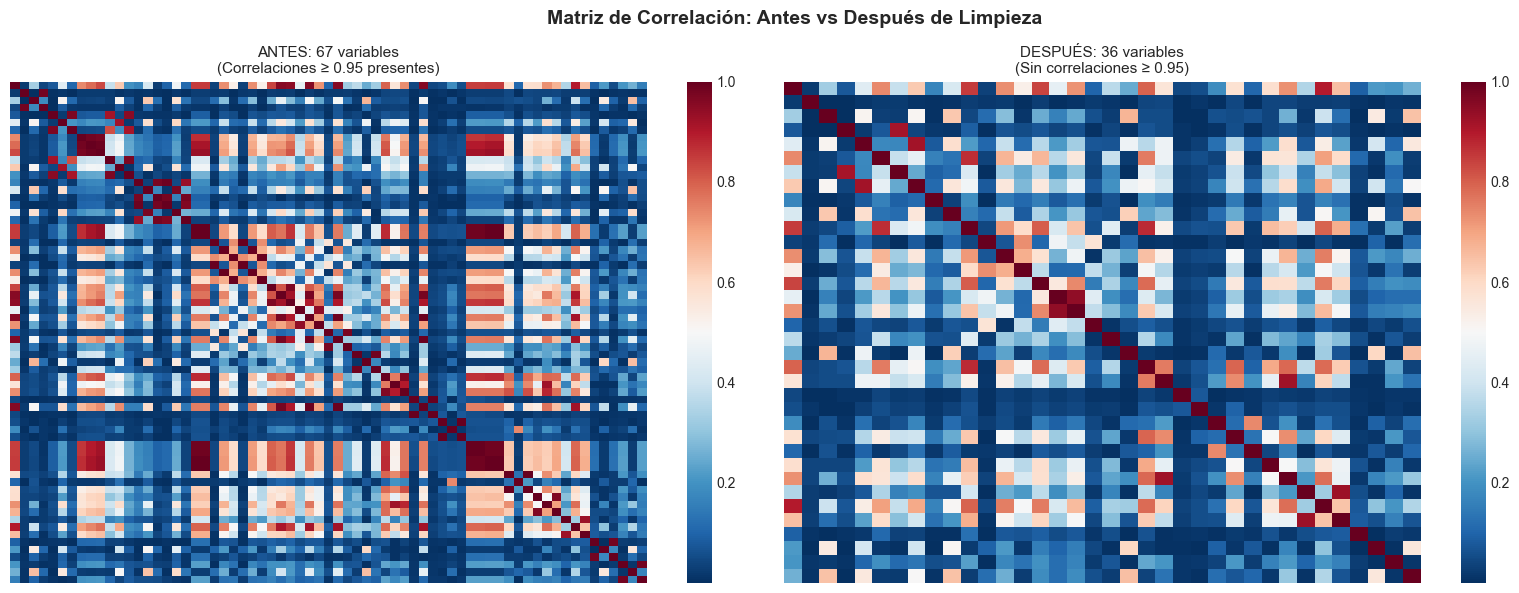


📊 Correlación máxima después de limpieza: 0.943


In [10]:
# ============================================================================
# 6.4 APLICAR ELIMINACIÓN Y VISUALIZAR RESULTADO
# ============================================================================

# Guardar dimensiones antes
shape_before_corr = df.shape

# Eliminar variables correlacionadas
df = df.drop(columns=list(vars_to_drop), errors='ignore')

print(f"\n✓ ELIMINACIÓN COMPLETADA")
print("="*60)
print(f"   Antes:  {shape_before_corr[1]} columnas")
print(f"   Después: {df.shape[1]} columnas")
print(f"   Eliminadas: {shape_before_corr[1] - df.shape[1]} columnas")

# Visualizar matriz de correlación después de limpieza
numeric_cols_after = df.select_dtypes(include='number').columns.tolist()
numeric_cols_after = [c for c in numeric_cols_after if c not in exclude_from_corr]

if len(numeric_cols_after) > 0:
    corr_after = df[numeric_cols_after].corr().abs()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Antes
    sns.heatmap(corr_matrix, ax=axes[0], cmap='RdBu_r', center=0.5,
                xticklabels=False, yticklabels=False)
    axes[0].set_title(f'ANTES: {len(corr_matrix)} variables\n(Correlaciones ≥ 0.95 presentes)', fontsize=11)
    
    # Después
    sns.heatmap(corr_after, ax=axes[1], cmap='RdBu_r', center=0.5,
                xticklabels=False, yticklabels=False)
    axes[1].set_title(f'DESPUÉS: {len(corr_after)} variables\n(Sin correlaciones ≥ 0.95)', fontsize=11)
    
    plt.suptitle('Matriz de Correlación: Antes vs Después de Limpieza', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Verificar que no quedan correlaciones altas
    max_corr_after = corr_after.where(np.triu(np.ones(corr_after.shape), k=1).astype(bool)).max().max()
    print(f"\n📊 Correlación máxima después de limpieza: {max_corr_after:.3f}")

## 7. Separación de Variables y Selección de Features

Separamos las columnas en tres categorías: identificadores (para trazabilidad), etiquetas (solo para evaluación posterior) y features numéricas (para los modelos).

In [11]:
# ============================================================================
# 7.1 DEFINIR COLUMNAS POR CATEGORÍA
# ============================================================================

# Identificadores (para trazabilidad)
id_cols = ['id.orig_h', 'window_start', 'window_end']
id_cols = [c for c in id_cols if c in df.columns]

# Etiquetas (variable objetivo - SOLO para evaluación)
label_cols = [c for c in df.columns if 'attack' in c.lower()]

# Features numéricas (excluir identificadores y etiquetas)
feature_cols = [c for c in df.columns if c not in id_cols + label_cols]

print("SEPARACIÓN DE COLUMNAS")
print("="*60)
print(f"\n📋 Identificadores ({len(id_cols)}):")
for col in id_cols:
    print(f"   • {col}")

print(f"\n📋 Etiquetas ({len(label_cols)}):")
for col in label_cols:
    print(f"   • {col}")

print(f"\n📋 Features numéricas: {len(feature_cols)} columnas")
print(f"   (Estas serán las variables de entrada para los modelos)")

SEPARACIÓN DE COLUMNAS

📋 Identificadores (3):
   • id.orig_h
   • window_start
   • window_end

📋 Etiquetas (6):
   • attack_phase_nunique
   • is_attack_count
   • is_attack_ratio
   • is_attack_any
   • is_attack_majority
   • is_attack

📋 Features numéricas: 36 columnas
   (Estas serán las variables de entrada para los modelos)


In [12]:
# ============================================================================
# 7.2 SEPARAR FEATURES Y ETIQUETAS
# ============================================================================

# Crear matriz de features X (excluyendo identificadores y etiquetas)
X = df.drop(columns=id_cols + label_cols, errors='ignore')

# Guardar etiqueta para evaluación (NO para entrenamiento)
y = df['is_attack_any'] if 'is_attack_any' in df.columns else df['is_attack']

print(f"\n📋 Features para modelado ({X.shape[1]}):")
print(f"   {list(X.columns)}")

print(f"\n{'='*60}")
print(f"RESUMEN DE SEPARACIÓN")
print(f"{'='*60}")
print(f"   Shape de features (X): {X.shape}")
print(f"   Shape de etiquetas (y): {y.shape}")
print(f"\n   Distribución de clases:")
print(f"   • Normal:  {(~y.astype(bool)).sum():,} ({(~y.astype(bool)).mean()*100:.1f}%)")
print(f"   • Ataque:  {y.astype(bool).sum():,} ({y.astype(bool).mean()*100:.1f}%)")


📋 Features para modelado (36):
   ['n_connections', 'id.orig_p_mean', 'id.orig_p_std', 'orig_bytes_mean', 'orig_bytes_std', 'resp_bytes_mean', 'bytes_ratio_mean', 'bytes_ratio_std', 'duration_mean', 'duration_std', 'conn_state_encoded_mean', 'conn_interval_mean', 'conn_interval_std', 'conn_interval_max', 'conn_count_10s_mean', 'conn_count_60s_mean', 'conn_count_60s_max', 'conn_count_300s_mean', 'interval_stddev_mean', 'interval_stddev_std', 'burst_score_mean', 'burst_score_std', 'total_conn_from_ip_mean', 'hour_of_day_mean', 'hour_of_day_std', 'ip_first_seen_hours_ago_mean', 'ip_first_seen_hours_ago_std', 'recon_pattern_score_mean', 'recon_pattern_score_std', 'recent_activity_score_mean', 'recent_activity_score_std', 'recent_activity_score_max', 'recent_docker_event_mean', 'recent_docker_event_std', 'time_since_container_start_mean', 'time_since_container_start_std']

RESUMEN DE SEPARACIÓN
   Shape de features (X): (24005, 36)
   Shape de etiquetas (y): (24005,)

   Distribución de cl

## 8. Dataset 1: Normalización para Isolation Forest y HDBSCAN (RobustScaler)

Para **Isolation Forest** y **HDBSCAN**, que no asumen distribuciones gaussianas, utilizamos **RobustScaler**:
- Centrado en la **mediana** (robusto ante outliers)
- Escalado por **rango intercuartílico IQR** (no se ve afectado por valores extremos)

In [13]:
# ============================================================================
# 8.1 APLICAR ROBUSTSCALER
# ============================================================================

scaler_robust = RobustScaler()
X_robust = scaler_robust.fit_transform(X)
X_robust_df = pd.DataFrame(X_robust, columns=X.columns, index=X.index)

print("DATASET 1: ROBUSTSCALER (Isolation Forest & HDBSCAN)")
print("="*60)
print(f"Shape: {X_robust_df.shape}")
print(f"\nEstadísticas tras escalado robusto:")
print(X_robust_df.describe().round(3))

DATASET 1: ROBUSTSCALER (Isolation Forest & HDBSCAN)
Shape: (24005, 36)

Estadísticas tras escalado robusto:
       n_connections  id.orig_p_mean  id.orig_p_std  orig_bytes_mean  \
count      24005.000       24005.000      24005.000        24005.000   
mean           0.158           0.004        525.434            0.012   
std            0.789           0.590       2349.557            0.493   
min            0.000          -1.028          0.000           -1.437   
25%            0.000          -0.502          0.000           -0.482   
50%            0.000           0.000          0.000            0.000   
75%            0.000           0.498          0.000            0.518   
max           13.000           1.054      22078.702            0.596   

       orig_bytes_std  resp_bytes_mean  bytes_ratio_mean  bytes_ratio_std  \
count       24005.000        24005.000         24005.000        24005.000   
mean            8.965            3.237             0.408            0.005   
std        

## 9. Dataset 2: Transformación y Normalización para GMM (PowerTransformer + StandardScaler)

Para **Gaussian Mixture Model (GMM)**, que asume distribuciones gaussianas:
1. **PowerTransformer (Yeo-Johnson)**: Transforma distribuciones asimétricas a distribuciones más normales
2. **StandardScaler**: Estandariza a media=0 y std=1

In [14]:
# ============================================================================
# 9.1 APLICAR POWERTRANSFORMER + STANDARDSCALER
# ============================================================================

# Paso 1: PowerTransformer (Yeo-Johnson) para normalizar distribuciones
power_transformer = PowerTransformer(method='yeo-johnson', standardize=False)
X_power = power_transformer.fit_transform(X)

# Paso 2: StandardScaler para estandarizar
scaler_standard = StandardScaler()
X_gmm = scaler_standard.fit_transform(X_power)
X_gmm_df = pd.DataFrame(X_gmm, columns=X.columns, index=X.index)

print("DATASET 2: POWERTRANSFORMER + STANDARDSCALER (GMM)")
print("="*60)
print(f"Shape: {X_gmm_df.shape}")
print(f"\nEstadísticas tras transformación:")
print(X_gmm_df.describe().round(3))

DATASET 2: POWERTRANSFORMER + STANDARDSCALER (GMM)
Shape: (24005, 36)

Estadísticas tras transformación:
       n_connections  id.orig_p_mean  id.orig_p_std  orig_bytes_mean  \
count      24005.000       24005.000      24005.000        24005.000   
mean          -0.000          -0.000         -0.000           -0.000   
std            1.000           1.000          1.000            1.000   
min           -0.307          -1.817         -0.307           -4.010   
25%           -0.307          -0.848         -0.307           -1.004   
50%           -0.307           0.023         -0.307            0.069   
75%           -0.307           0.845         -0.307            1.025   
max            3.257           1.722          3.282            1.155   

       orig_bytes_std  resp_bytes_mean  bytes_ratio_mean  bytes_ratio_std  \
count       24005.000        24005.000         24005.000        24005.000   
mean           -0.000            0.000            -0.000           -0.000   
std            

In [15]:
# ============================================================================
# 9.2 VALIDACIÓN DE LA NORMALIZACIÓN
# ============================================================================

# Comparar asimetría (skewness) antes y después
skewness_original = X.skew().sort_values(ascending=False)
skewness_gmm = X_gmm_df.skew().sort_values(ascending=False)

comparison = pd.DataFrame({
    'skew_original': skewness_original,
    'skew_gmm': skewness_gmm,
    'mejora': np.abs(skewness_original) - np.abs(skewness_gmm)
}).sort_values('mejora', ascending=False)

print("COMPARACIÓN DE ASIMETRÍA (SKEWNESS)")
print("="*60)
print(f"\nTop 10 variables con mayor mejora:")
print(comparison.head(10).round(3))

print(f"\n{'='*60}")
print(f"Skewness medio original:    {np.abs(skewness_original).mean():.3f}")
print(f"Skewness medio GMM:         {np.abs(skewness_gmm).mean():.3f}")
print(f"Mejora promedio:            {comparison['mejora'].mean():.3f}")

COMPARACIÓN DE ASIMETRÍA (SKEWNESS)

Top 10 variables con mayor mejora:
                             skew_original  skew_gmm  mejora
ip_first_seen_hours_ago_std         39.627    19.871  19.756
conn_interval_std                    9.544     2.979   6.565
n_connections                        8.802     2.949   5.852
conn_count_10s_mean                  8.133     2.509   5.624
conn_interval_max                    5.602     0.004   5.598
conn_count_60s_max                   4.058     0.445   3.613
recon_pattern_score_std              6.035     3.134   2.901
recent_activity_score_max            2.843    -0.029   2.814
recent_activity_score_std            5.618     3.038   2.580
recon_pattern_score_mean             2.498    -0.018   2.480

Skewness medio original:    5.636
Skewness medio GMM:         3.487
Mejora promedio:            2.149


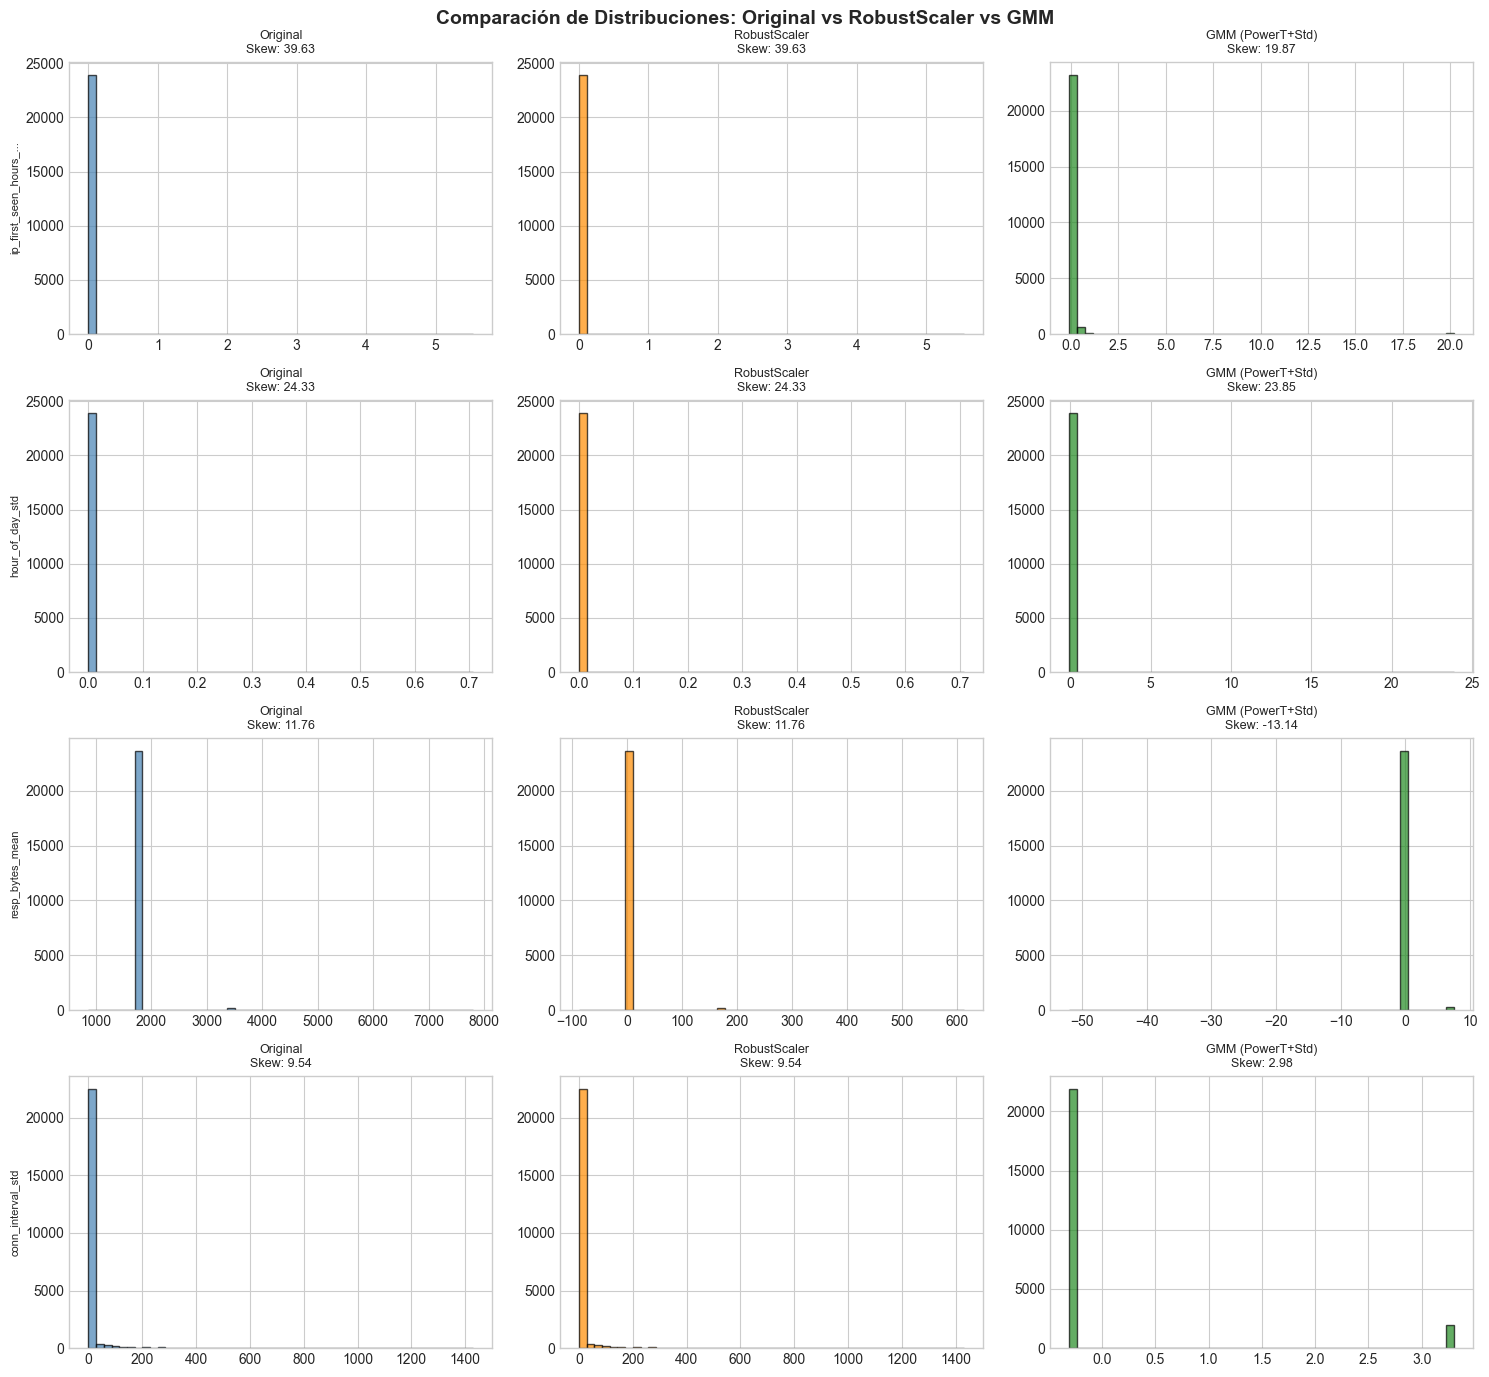

In [16]:
# ============================================================================
# 9.3 VISUALIZACIÓN: COMPARACIÓN DE DISTRIBUCIONES
# ============================================================================

# Seleccionar 4 features con mayor asimetría original
features_to_plot = skewness_original.head(4).index

fig, axes = plt.subplots(4, 3, figsize=(15, 14))
fig.suptitle('Comparación de Distribuciones: Original vs RobustScaler vs GMM', fontsize=14, fontweight='bold')

for idx, feature in enumerate(features_to_plot):
    # Original
    axes[idx, 0].hist(X[feature], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[idx, 0].set_title(f'Original\nSkew: {X[feature].skew():.2f}', fontsize=9)
    axes[idx, 0].set_ylabel(feature[:20] + '...' if len(feature) > 20 else feature, fontsize=8)
    
    # RobustScaler
    axes[idx, 1].hist(X_robust_df[feature], bins=50, edgecolor='black', alpha=0.7, color='darkorange')
    axes[idx, 1].set_title(f'RobustScaler\nSkew: {X_robust_df[feature].skew():.2f}', fontsize=9)
    
    # GMM
    axes[idx, 2].hist(X_gmm_df[feature], bins=50, edgecolor='black', alpha=0.7, color='forestgreen')
    axes[idx, 2].set_title(f'GMM (PowerT+Std)\nSkew: {X_gmm_df[feature].skew():.2f}', fontsize=9)

plt.tight_layout()
plt.show()

## 10. Exportación de Datasets

Guardamos los datasets preprocesados junto con los transformadores para poder aplicar las mismas transformaciones a datos nuevos en producción.

In [19]:
import joblib
import os

# Crear directorio para transformadores si no existe
os.makedirs('../models/transformers', exist_ok=True)

# ============================================================================
# EXPORTAR DATASETS PREPROCESADOS
# ============================================================================

# 1. Dataset para Isolation Forest y HDBSCAN (RobustScaler)
X_robust_df.to_csv('../data/processed/X_robust_scaled.csv', index=False)
print("✓ Dataset RobustScaler guardado: ../data/processed/X_robust_scaled.csv")

# 2. Dataset para GMM (PowerTransformer + StandardScaler)
X_gmm_df.to_csv('../data/processed/X_gmm_transformed.csv', index=False)
print("✓ Dataset GMM guardado: ../data/processed/X_gmm_transformed.csv")

# 3. Etiquetas (para evaluación posterior)
y.to_csv('../data/processed/y_labels.csv', index=False)
print("✓ Etiquetas guardadas: ../data/processed/y_labels.csv")

# 4. Metadatos (identificadores y columnas de contexto)
df_metadata = df[id_cols + label_cols]
df_metadata.to_csv('../data/processed/metadata.csv', index=False)
print("✓ Metadatos guardados: ../data/processed/metadata.csv")

# ============================================================================
# EXPORTAR TRANSFORMADORES (para uso en producción)
# ============================================================================

# Guardar transformadores para aplicar a datos nuevos
joblib.dump(scaler_robust, '../models/transformers/robust_scaler.joblib')
print("✓ RobustScaler guardado: ../models/transformers/robust_scaler.joblib")

joblib.dump(power_transformer, '../models/transformers/power_transformer.joblib')
print("✓ PowerTransformer guardado: ../models/transformers/power_transformer.joblib")

joblib.dump(scaler_standard, '../models/transformers/standard_scaler.joblib')
print("✓ StandardScaler guardado: ../models/transformers/standard_scaler.joblib")

# Guardar lista de features
feature_names = X.columns.tolist()
joblib.dump(feature_names, '../models/transformers/feature_names.joblib')
print("✓ Lista de features guardada: ../models/transformers/feature_names.joblib")

✓ Dataset RobustScaler guardado: ../data/processed/X_robust_scaled.csv
✓ Dataset GMM guardado: ../data/processed/X_gmm_transformed.csv
✓ Etiquetas guardadas: ../data/processed/y_labels.csv
✓ Metadatos guardados: ../data/processed/metadata.csv
✓ RobustScaler guardado: ../models/transformers/robust_scaler.joblib
✓ PowerTransformer guardado: ../models/transformers/power_transformer.joblib
✓ StandardScaler guardado: ../models/transformers/standard_scaler.joblib
✓ Lista de features guardada: ../models/transformers/feature_names.joblib


In [20]:
# Verificar archivos exportados
print("\n" + "=" * 70)
print("RESUMEN DE ARCHIVOS EXPORTADOS")
print("=" * 70)

# Datasets
print("\n📁 Datasets preprocesados:")
datasets = [
    '../data/processed/X_robust_scaled.csv',
    '../data/processed/X_gmm_transformed.csv',
    '../data/processed/y_labels.csv',
    '../data/processed/metadata.csv'
]
for path in datasets:
    size = os.path.getsize(path) / 1024  # KB
    print(f"   {path}: {size:.1f} KB")

# Transformadores
print("\n🔧 Transformadores:")
transformers = [
    '../models/transformers/robust_scaler.joblib',
    '../models/transformers/power_transformer.joblib',
    '../models/transformers/standard_scaler.joblib',
    '../models/transformers/feature_names.joblib'
]
for path in transformers:
    size = os.path.getsize(path) / 1024  # KB
    print(f"   {path}: {size:.1f} KB")


RESUMEN DE ARCHIVOS EXPORTADOS

📁 Datasets preprocesados:
   ../data/processed/X_robust_scaled.csv: 9227.2 KB
   ../data/processed/X_gmm_transformed.csv: 16884.7 KB
   ../data/processed/y_labels.csv: 70.3 KB
   ../data/processed/metadata.csv: 1479.5 KB

🔧 Transformadores:
   ../models/transformers/robust_scaler.joblib: 2.1 KB
   ../models/transformers/power_transformer.joblib: 1.7 KB
   ../models/transformers/standard_scaler.joblib: 1.4 KB
   ../models/transformers/feature_names.joblib: 0.8 KB


## 11. Resumen de Transformaciones Aplicadas

Resumen detallado de todas las transformaciones aplicadas a los datos originales.

In [21]:
# Crear resumen detallado de transformaciones
print("=" * 80)
print("RESUMEN COMPLETO DEL PREPROCESAMIENTO")
print("=" * 80)

print("\n📋 DATOS DE ENTRADA")
print("-" * 40)
print(f"   Archivo origen: windowed_dataset.csv")

print("\n📋 TRANSFORMACIONES APLICADAS")
print("-" * 40)

print("\n   1️⃣  Eliminación de columnas constantes")
print(f"      - {len(constant_cols)} columnas eliminadas por tener un único valor")

print("\n   2️⃣  Eliminación de columnas con baja varianza")
print(f"      - {len(low_variance_cols)} columnas eliminadas (>99% mismo valor)")

print("\n   3️⃣  Tratamiento de valores nulos")
print(f"      - Columnas *_std: imputadas con 0 ({len(std_cols)} columnas)")
print(f"      - Columnas time_since_last_conn_*: imputadas con 0")
print(f"      - Columnas restantes: imputadas con mediana")

print("\n   4️⃣  Eliminación de variables altamente correlacionadas")
print(f"      - Umbral de correlación: {CORRELATION_THRESHOLD}")
print(f"      - {len(vars_to_drop)} columnas eliminadas por correlación ≥ {CORRELATION_THRESHOLD}")

print("\n   5️⃣  Separación de columnas")
print(f"      - Identificadores: {id_cols}")
print(f"      - Etiquetas: {label_cols}")
print(f"      - Features numéricas: {len(X.columns)} columnas")

print("\n   6️⃣  Normalización para IF y HDBSCAN (Dataset 1)")
print(f"      - Método: RobustScaler")
print(f"      - Centrado: mediana")
print(f"      - Escalado: rango intercuartílico (IQR)")

print("\n   7️⃣  Transformación para GMM (Dataset 2)")
print(f"      - Paso 1: PowerTransformer (Yeo-Johnson)")
print(f"      - Paso 2: StandardScaler (media=0, std=1)")

print("\n📋 DATOS DE SALIDA")
print("-" * 40)
print(f"   Dataset 1 (IF & HDBSCAN): X_robust_scaled.csv    - Shape: {X_robust_df.shape}")
print(f"   Dataset 2 (GMM):          X_gmm_transformed.csv  - Shape: {X_gmm_df.shape}")
print(f"   Etiquetas:                y_labels.csv           - Shape: ({len(y)},)")
print(f"   Metadatos:                metadata.csv")

RESUMEN COMPLETO DEL PREPROCESAMIENTO

📋 DATOS DE ENTRADA
----------------------------------------
   Archivo origen: windowed_dataset.csv

📋 TRANSFORMACIONES APLICADAS
----------------------------------------

   1️⃣  Eliminación de columnas constantes
      - 11 columnas eliminadas por tener un único valor

   2️⃣  Eliminación de columnas con baja varianza
      - 7 columnas eliminadas (>99% mismo valor)

   3️⃣  Tratamiento de valores nulos
      - Columnas *_std: imputadas con 0 (20 columnas)
      - Columnas time_since_last_conn_*: imputadas con 0
      - Columnas restantes: imputadas con mediana

   4️⃣  Eliminación de variables altamente correlacionadas
      - Umbral de correlación: 0.95
      - 31 columnas eliminadas por correlación ≥ 0.95

   5️⃣  Separación de columnas
      - Identificadores: ['id.orig_h', 'window_start', 'window_end']
      - Etiquetas: ['attack_phase_nunique', 'is_attack_count', 'is_attack_ratio', 'is_attack_any', 'is_attack_majority', 'is_attack']
      

## 12. Conclusiones

### 12.1 Resumen del Preprocesamiento

El proceso de preprocesamiento ha transformado el dataset de ventanas deslizantes (`windowed_dataset.csv`) en dos conjuntos de datos optimizados para diferentes algoritmos de detección de anomalías:

| Aspecto | Dataset Original | Dataset RobustScaler | Dataset GMM |
|---------|------------------|----------------------|-------------|
| **Algoritmo destino** | - | Isolation Forest, HDBSCAN | GMM |
| **Transformación** | - | RobustScaler | PowerTransformer + StandardScaler |
| **Asimetría (skew)** | Alta | Preservada | Reducida (~0) |
| **Outliers** | Presentes | Preservados | Atenuados (pero distinguibles) |
| **Suposición de normalidad** | No cumplida | No requerida | Aproximadamente cumplida |

### 12.2 Pipeline de Transformaciones Aplicado

```
┌─────────────────────────────────────────────────────────────────────────────┐
│                         PIPELINE DE PREPROCESAMIENTO                        │
└─────────────────────────────────────────────────────────────────────────────┘
                                     │
                    ┌────────────────▼────────────────┐
                    │    1. Eliminación Constantes    │
                    │    (Variables con 1 único       │
                    │     valor - sin información)    │
                    └────────────────┬────────────────┘
                                     │
                    ┌────────────────▼────────────────┐
                    │   2. Eliminación Baja Varianza  │
                    │    (>99% mismo valor - casi     │
                    │         sin información)        │
                    └────────────────┬────────────────┘
                                     │
                    ┌────────────────▼────────────────┐
                    │   3. Tratamiento de Nulos       │
                    │    • *_std → 0 (std=0 para n=1) │
                    │    • Temporales → 0 (sin        │
                    │      historial)                 │
                    │    • Resto → mediana            │
                    └────────────────┬────────────────┘
                                     │
                    ┌────────────────▼────────────────┐
                    │  4. Eliminación Correlacionadas │
                    │    (Variables con ρ ≥ 0.95      │
                    │     son redundantes)            │
                    └────────────────┬────────────────┘
                                     │
                    ┌────────────────▼────────────────┐
                    │   5. Separación de Variables    │
                    │    • Identificadores (IPs,      │
                    │      timestamps)                │
                    │    • Etiquetas (solo eval)      │
                    │    • Features numéricas         │
                    └────────────────┬────────────────┘
                                     │
              ┌──────────────────────┴──────────────────────┐
              │                                             │
   ┌──────────▼──────────┐                    ┌─────────────▼─────────────┐
   │   6. RobustScaler   │                    │ 7. PowerT + StandardScaler│
   │  (mediana + IQR)    │                    │  (normalización gaussiana)│
   └──────────┬──────────┘                    └─────────────┬─────────────┘
              │                                             │
   ┌──────────▼──────────┐                    ┌─────────────▼─────────────┐
   │   X_robust_scaled   │                    │    X_gmm_transformed      │
   │  (IF & HDBSCAN)     │                    │        (GMM)              │
   └─────────────────────┘                    └───────────────────────────┘
```

### 12.3 Decisiones Clave Tomadas

**1. Eliminación de variables sin información (constantes + baja varianza)**
- Variables constantes no discriminan entre clases
- Variables con >99% mismo valor aportan información marginal
- Reducción de dimensionalidad mejora eficiencia

**2. Eliminación de variables redundantes (correlación ≥ 0.95)**
- Variables altamente correlacionadas proporcionan información redundante
- Mantener ambas puede causar inestabilidad numérica en algunos algoritmos
- Reducción de dimensionalidad sin pérdida significativa de información

**3. Preservación de outliers**
- Los outliers representan comportamientos anómalos (potenciales ataques)
- NO se eliminaron, ya que contienen la información que queremos detectar
- Se utilizó RobustScaler que minimiza el impacto sin eliminarlos

**4. Tratamiento contextual de valores nulos**
- Los nulos en columnas `*_std` se imputaron con 0 (varianza nula para una única observación)
- Los nulos en métricas temporales se imputaron con 0 (primera conexión, sin historial)

**5. Normalización diferenciada por algoritmo**
- IF y HDBSCAN no requieren distribuciones gaussianas → RobustScaler
- GMM asume gaussianidad → PowerTransformer + StandardScaler

### 12.4 Artefactos Generados

Los siguientes archivos están listos para el entrenamiento de modelos:

```
📁 data/processed/
├── X_robust_scaled.csv       # Features para IF y HDBSCAN
├── X_gmm_transformed.csv     # Features para GMM
├── y_labels.csv              # Etiquetas (solo evaluación)
└── metadata.csv              # Identificadores y contexto

📁 models/transformers/
├── robust_scaler.joblib      # Para transformar datos nuevos (IF/HDBSCAN)
├── power_transformer.joblib  # Para transformar datos nuevos (GMM)
├── standard_scaler.joblib    # Para escalar datos nuevos (GMM)
└── feature_names.joblib      # Lista de features esperadas
```

### 12.5 Próximos Pasos

El preprocesamiento está completo y los datos están listos para:

1. **Notebook 03_modeling_isolation_forest**: Entrenar y evaluar modelo basado en árboles
2. **Notebook 03_modeling_hdbscan**: Entrenar y evaluar clustering basado en densidad  
3. **Notebook 03_modeling_gmm**: Entrenar y evaluar modelo de mezcla de gaussianas
4. **Notebook 04_evaluation**: Comparar rendimiento de los tres modelos

### 12.6 Consideraciones para Producción

Para aplicar el preprocesamiento a datos nuevos en producción:

```python
# Ejemplo de uso de los transformadores guardados
import joblib
import pandas as pd

# Cargar transformadores
robust_scaler = joblib.load('models/transformers/robust_scaler.joblib')
power_transformer = joblib.load('models/transformers/power_transformer.joblib')
standard_scaler = joblib.load('models/transformers/standard_scaler.joblib')
feature_names = joblib.load('models/transformers/feature_names.joblib')

# Transformar datos nuevos para IF/HDBSCAN
X_new_robust = robust_scaler.transform(df_new[feature_names])

# Transformar datos nuevos para GMM
X_new_power = power_transformer.transform(df_new[feature_names])
X_new_gmm = standard_scaler.transform(X_new_power)
```

---
**Fin del Notebook de Preprocesamiento**